Graph has more than 1 node, chromatic number cannot be 0 or 1.
One way color configurations:  [(1, 0), (0, 1)]
Sample:  {'a0': 0, 'a1': 0, 'b0': 1, 'b1': 0, 'c0': 0, 'c1': 1, 'd0': 1, 'd1': 0}


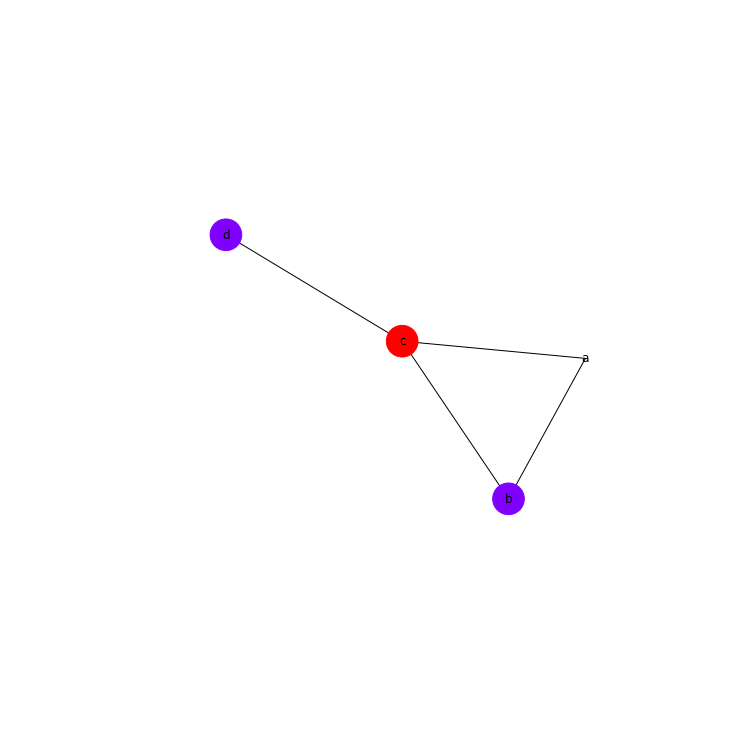

Failed to find a 2-coloring for this graph.
One way color configurations:  [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
Sample:  {'a0': 1, 'a1': 0, 'a2': 0, 'b0': 0, 'b1': 0, 'b2': 1, 'c0': 0, 'c1': 1, 'c2': 0, 'd0': 0, 'd1': 0, 'd2': 1}
Found a 3-coloring for this graph.


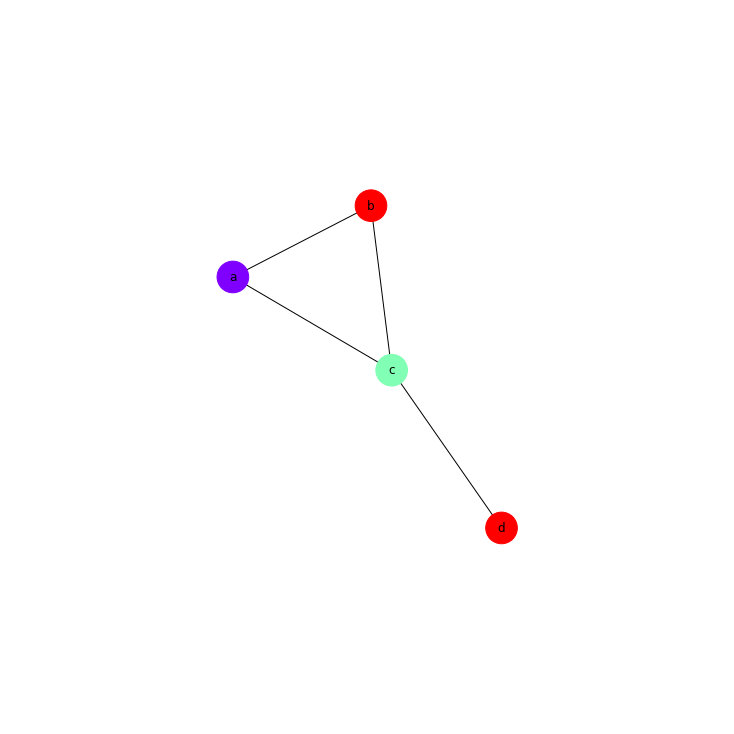

SystemExit: 

In [1]:
# Part of this code comes from https://docs.ocean.dwavesys.com/en/latest/examples/map_coloring.html
# I wrote the code to generate the color configurations, max degree, and to calculate the chromatic number
import dwavebinarycsp
from dwave.system import DWaveSampler, EmbeddingComposite
import networkx as nx
import matplotlib.pyplot as plt
import sys

provinces = ['a', 'b', 'c', 'd']
neighbors = [('a', 'b'), ('a', 'c'), ('b', 'c'), ('c', 'd')]

# Function for the constraint that two nodes with a shared edge not both select one color
def not_both_1(v, u):
    return not (v and u)

# Function that plots a returned sample
def plot_map(sample, G):
    # Translate from binary to integer color representation
    color_map = {}
    for province in provinces:
          for i in range(colors):
            if sample[province+str(i)]:
                color_map[province] = i
    # Plot the sample with color-coded nodes
    node_colors = [color_map.get(node) for node in G.nodes()]
    plt.figure(figsize=(10, 10))
    nx.draw(G, with_labels=True, node_color=node_colors, node_size=1000, cmap=plt.cm.rainbow)
    l,r = plt.xlim()
    plt.xlim(l-1, r+1)
    u,d = plt.ylim()
    plt.ylim(u-1, d+1)
    plt.show()

def generate_color_configurations(n):
  color_configurations = []
  for i in range(n):
    color = [0] * n
    color[i] = 1
    color_configurations.append(tuple(color))
  return color_configurations

def find_max_degree(G):
  max = 0
  for node in list(G.nodes):
    if G.degree[node] > max:
      max = G.degree[node]
  return max  

G = nx.Graph()
G.add_nodes_from(provinces)
G.add_edges_from(neighbors)
max_chromatic_num = find_max_degree(G) + 1
chromatic_num = 0
if(len(provinces)==0):
  print("Chromatic number is %" %chromatic_num)
  sys.exit()
elif(len(provinces) == 1):
  chromatic_num = 1
  print("Chromatic number is %" %chromatic_num)
  sys.exit()
else:
  print("Graph has more than 1 node, chromatic number cannot be 0 or 1.")
  chromatic_num = 2
while(chromatic_num <= max_chromatic_num):
# Valid configurations for the constraint that each node select a single color
  colors = chromatic_num
  one_color_configurations = generate_color_configurations(colors)
  print("One way color configurations: ", one_color_configurations)

  # Create a binary constraint satisfaction problem
  csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

  # Add constraint that each node (province) select a single color
  for province in provinces:
      variables = [province+str(i) for i in range(colors)]
      csp.add_constraint(one_color_configurations, variables)

  # Add constraint that each pair of nodes with a shared edge not both select one color
  for neighbor in neighbors:
      v, u = neighbor
      for i in range(colors):
          variables = [v+str(i), u+str(i)]
          csp.add_constraint(not_both_1, variables)

  # Convert the binary constraint satisfaction problem to a binary quadratic model
  bqm = dwavebinarycsp.stitch(csp)

  sampler = EmbeddingComposite(DWaveSampler())
  sampleset = sampler.sample(bqm, num_reads=1000)

  # Plot the lowest-energy sample if it meets the constraints
  sample = sampleset.first.sample
  if not csp.check(sample):
      print("Sample: ", sample)
      plot_map(sample, G)
      print("Failed to find a %s-coloring for this graph." % chromatic_num)
  else:
      print("Sample: ", sample)
      print("Found a %s-coloring for this graph." % chromatic_num)
      plot_map(sample, G)
      sys.exit()
  chromatic_num = chromatic_num + 1